# Imports and Paths

In [7]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths
DATA_PATH = "influences_sample.csv"

# Set random seed for reproducibility
np.random.seed(42)


# Load Data

In [24]:
data = {
    "influencer": [
        "Socrates", "Plato", "Aristotle", "Thomas Aquinas", "Descartes", "Spinoza", "Locke", "Hume", "Kant", "Hegel", "Schopenhauer", "Nietzsche", "Heidegger"
    ],
    "influenced": [
        "Plato", "Aristotle", "Thomas Aquinas", "Descartes", "Spinoza", "Locke", "Hume", "Kant", "Hegel", "Schopenhauer", "Nietzsche", "Heidegger", "Nietzsche"
    ],
    "school": [
        "Ancient", "Ancient", "Ancient", "Medieval", "Modern", "Modern", "Modern", "Modern", "Modern", "German Idealism", "German Idealism", "German Idealism", "Existentialism"
    ],
    "year_influencer": [
        "469 BC", "427 BC", "384 BC", "1225", "1596", "1632", "1632", "1711", "1724", "1770", "1788", "1844", "1889"
    ]
}

df = pd.DataFrame(data)
df.to_csv("influences_sample.csv", index=False)

In [25]:
print(df.columns.tolist())

['influencer', 'influenced', 'school', 'year_influencer']


We start by loading a small dataset of philosophers and their influences. Each row represents a directed connection from an influencer to someone they influenced.

# Prepare Nodes and Edges

In [26]:
# Create a unique list of nodes
nodes = list(set(df['influencer']).union(set(df['influenced'])))
n_nodes = len(nodes)

# Map names to indices
node_index = {node: i for i, node in enumerate(nodes)}

# Initialize random 2D positions for visualization
positions = np.random.rand(n_nodes, 2) * 10

# Create edge list as tuples of indices
edges = [(node_index[row['influencer']], node_index[row['influenced']]) for idx, row in df.iterrows()]

print(f"Total nodes: {n_nodes}, Total edges: {len(edges)}")

Total nodes: 13, Total edges: 13


We assign each philosopher a position in 2D space and prepare the connections for plotting. This allows us to visualize the network mathematically.

# Plot Network

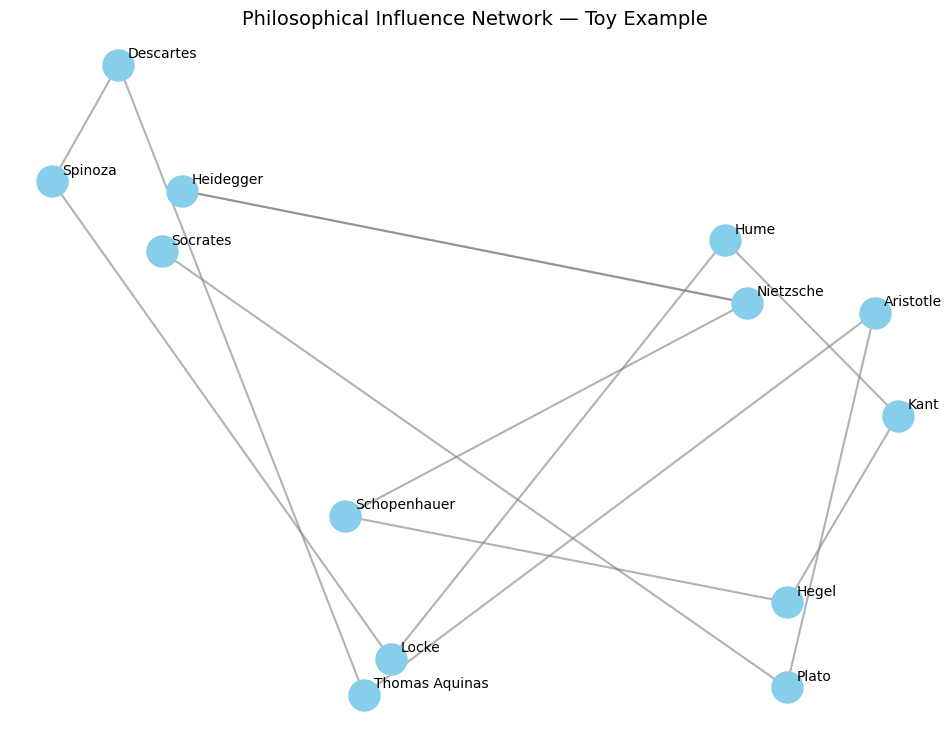

In [27]:
plt.figure(figsize=(12, 9))

# Draw edges
for i, j in edges:
    x = [positions[i, 0], positions[j, 0]]
    y = [positions[i, 1], positions[j, 1]]
    plt.plot(x, y, color='gray', alpha=0.6, zorder=1)

# Draw nodes
plt.scatter(positions[:,0], positions[:,1], s=500, color='skyblue', zorder=2)

for i, node in enumerate(nodes):
    plt.text(positions[i,0]+0.1, positions[i,1]+0.1, node, fontsize=10)

plt.title("Philosophical Influence Network — Toy Example", fontsize=14)
plt.axis('off')

plt.show()

Edges represent influences, while node positions are randomly initialized. Later, we can improve layout using physics-inspired forces.

# Color nodes by school + physics layout

In this step, we enhance our network visualization by adding more informative and visually appealing features:

1. **Node Colors by School**: Each philosopher is colored according to their philosophical school. This allows us to easily see clusters of thinkers who share similar traditions or intellectual backgrounds.

2. **Node Sizes by Influence Count**: The size of each node is proportional to the number of philosophers they influenced. Philosophers with a greater impact on others appear larger.

3. **Physics-Based Layout**: We apply a simple force simulation to arrange the nodes:
   - **Repulsive forces** prevent nodes from overlapping.
   - **Attractive forces** along edges pull influenced philosophers towards their influencers.




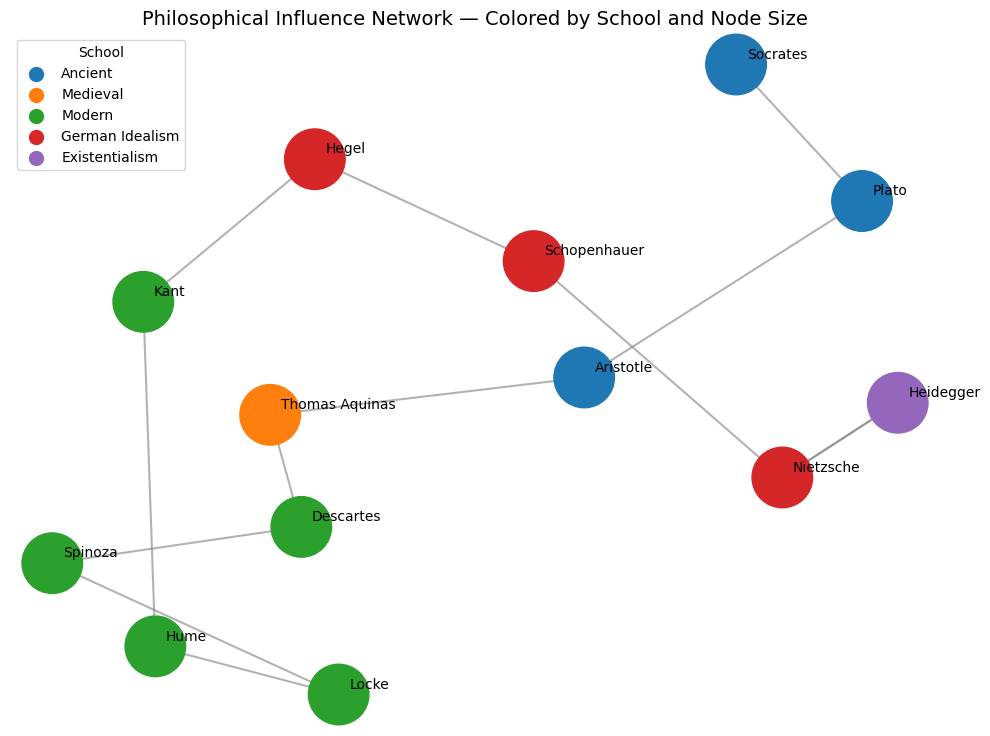

In [40]:
# Map school to colors
schools = df['school'].unique()
color_map = {school: plt.cm.tab10(i % 10) for i, school in enumerate(schools)}

# Assign color to each node
node_colors = []
node_sizes = []
influence_counts = df['influencer'].value_counts()

for node in nodes:
    # Get school for this node
    school_row = df[df['influencer'] == node]
    if not school_row.empty:
        school = school_row['school'].iloc[0]
    else:
        # If never influencer, try influenced
        school_row = df[df['influenced'] == node]
        if not school_row.empty:
            school = school_row['school'].iloc[0]
        else:
            school = 'Unknown'
    node_colors.append(color_map.get(school, 'gray'))

    # Node size proportional to influence count
    node_sizes.append(300 + (influence_counts.get(node,0)+1)*800)

node_colors = np.array(node_colors)
node_sizes = np.array(node_sizes)

# Simple physics layout
positions = np.random.rand(n_nodes, 2) * 10
velocities = np.zeros_like(positions)
dt = 0.1
k_repulsion = 0.5
k_attraction = 0.05

for step in range(200):  # 200 iterations
    forces = np.zeros_like(positions)

    # Repulsion between all nodes
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            delta = positions[i] - positions[j]
            distance = np.linalg.norm(delta) + 1e-4
            f = k_repulsion / distance**2
            forces[i] += (delta/distance)*f
            forces[j] -= (delta/distance)*f

    # Attraction along edges (influencer -> influenced)
    for i, j in edges:
        delta = positions[j] - positions[i]
        distance = np.linalg.norm(delta) + 1e-4
        f = k_attraction * distance
        forces[i] += delta/distance * f
        forces[j] -= delta/distance * f

    # Update positions
    velocities = 0.8*velocities + forces*dt
    positions += velocities*dt

plt.figure(figsize=(12,9))

# Draw edges
for i, j in edges:
    x = [positions[i,0], positions[j,0]]
    y = [positions[i,1], positions[j,1]]
    plt.plot(x, y, color='gray', alpha=0.6, zorder=1)

# Draw nodes with colors and sizes
plt.scatter(positions[:,0], positions[:,1], s=node_sizes, c=node_colors, zorder=2)

# Labels
for i, node in enumerate(nodes):
    plt.text(positions[i,0]+0.1, positions[i,1]+0.1, node, fontsize=10)

plt.legend(legend_handles, legend_labels,
           title="School",
           loc='upper left',
           frameon=True)

plt.title("Philosophical Influence Network — Colored by School and Node Size", fontsize=14)
plt.axis('off')
plt.show()
